In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Use test equation



In [2]:
# stability region for Euler forward for this problem is h<2/50=0.04
def func(t, y):
    return -50*np.eye(len(y))@y
def jacobian(y):
    return -50*np.eye(len(y))


t_eval = np.linspace(0,2.5,10)
y0 = np.array([0.5, 0.7, 1.0, 3.0])

## No Jacobian

Text(0, 0.5, 'Number of equations per level')

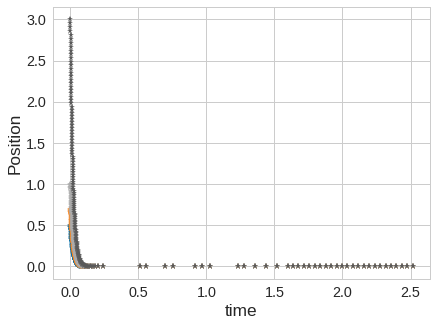

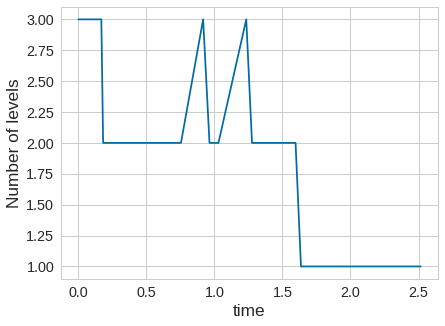

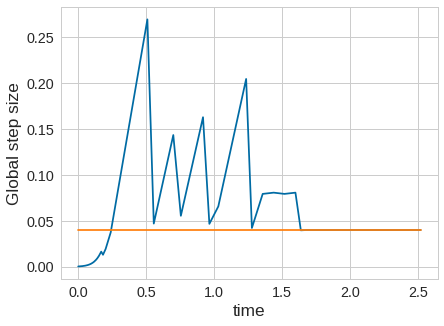

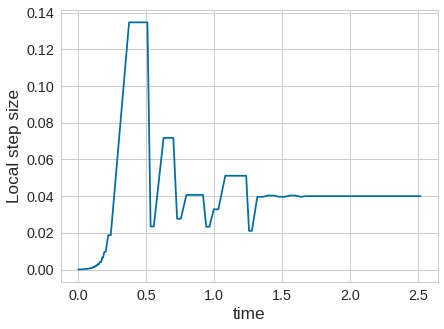

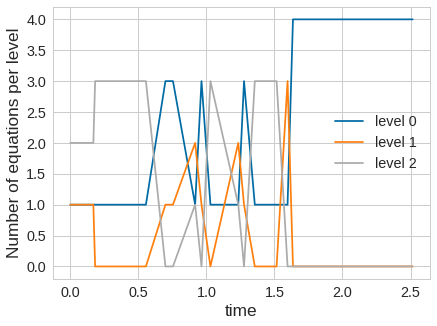

In [3]:

try:
    os.remove('step_sizes.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('step_sizes_local.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('levels.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('n_eq_per_level.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs.txt')
except FileNotFoundError:
    print('Nothing to delete.')

sol2 = ef.solve_ivp(func, [t_eval[0], t_eval[-1]], y0, t_eval=None, eps=0.0001, eta = 0.00001, local_adaptivity=True, write_to_file=True)
plt.plot(sol2.t, sol2.y.T, '*')
plt.xlabel('time')
plt.ylabel('Position')

plt.figure()
ts = np.loadtxt('time_points.txt')
lev  = np.loadtxt('levels.txt')
plt.plot(ts[1:], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt  = np.loadtxt('step_sizes.txt')
plt.plot(np.cumsum(dt), dt)
plt.plot(np.cumsum(dt), 0.04*np.ones(len(np.cumsum(dt))))
plt.xlabel('time')
plt.ylabel('Global step size')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local.txt')
plt.plot(np.cumsum(dt_locals), dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level.txt')
plt.plot(ts[1:], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[1:], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[1:], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

## With Jacobian

Text(0, 0.5, 'Number of equations per level')

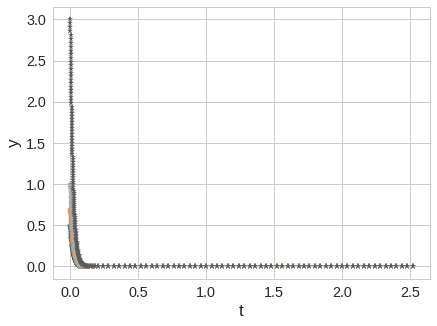

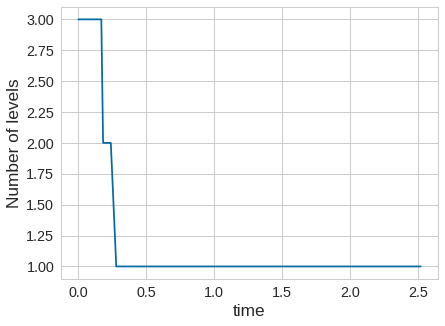

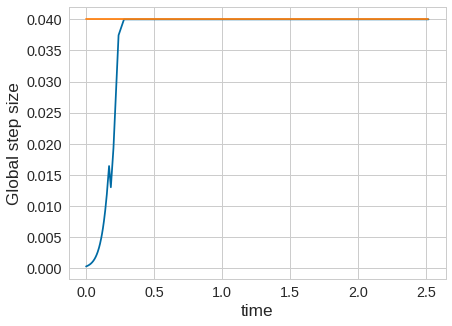

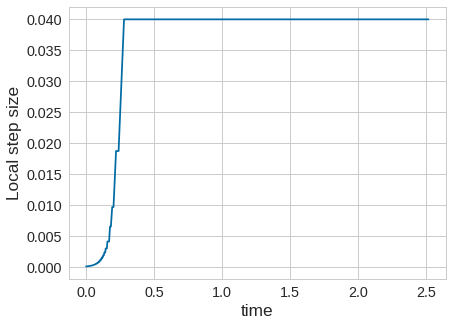

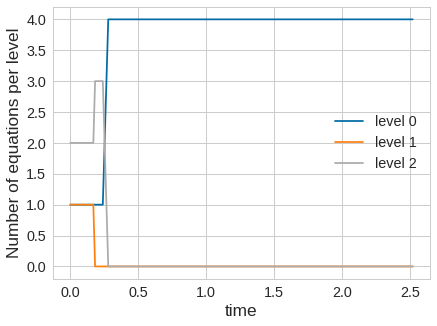

In [4]:
try:
    os.remove('step_sizes.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('step_sizes_local.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('levels.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('n_eq_per_level.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs.txt')
except FileNotFoundError:
    print('Nothing to delete.')


sol2 = ef.solve_ivp(func, [t_eval[0], t_eval[-1]], y0, t_eval=None,
                 eps=0.0001, eta = 0.00001, local_adaptivity=True,
                 write_to_file=True, jacobian=jacobian)
#plt.plot(sol2.t, sol2.y.T)
plt.plot(sol2.t, sol2.y.T, '*')
plt.xlabel('t')
plt.ylabel('y')

plt.figure()
ts = np.loadtxt('time_points.txt')
lev  = np.loadtxt('levels.txt')
plt.plot(ts[1:], lev)
plt.xlabel('time')
plt.ylabel('Number of levels')

plt.figure()
dt  = np.loadtxt('step_sizes.txt')
plt.plot(np.cumsum(dt), dt)
plt.plot(np.cumsum(dt), 0.04*np.ones(len(np.cumsum(dt))))
plt.xlabel('time')
plt.ylabel('Global step size')

plt.figure()
dt_locals  = np.loadtxt('step_sizes_local.txt')
plt.plot(np.cumsum(dt_locals), dt_locals)
plt.xlabel('time')
plt.ylabel('Local step size')

plt.figure()
n_eq_per_level = np.loadtxt('n_eq_per_level.txt')
plt.plot(ts[1:], n_eq_per_level[0,:], label='level 0')
plt.plot(ts[1:], n_eq_per_level[1,:], label='level 1')
plt.plot(ts[1:], n_eq_per_level[2,:], label='level 2')
plt.legend()
plt.xlabel('time')
plt.ylabel('Number of equations per level')

#plt.figure()
#AFs = np.loadtxt('AFs.txt')
#sorted_AFs = -np.sort(-abs(AFs))
#plt.plot(sorted_AFs[0, :], label='$t=t_1$')
#plt.plot(sorted_AFs[1,:], label='$t=t_2$')
#plt.plot(sorted_AFs[2,:], label='$t=t_3$')

#plt.plot(sorted_AFs[-2,:], label='$t=t_f$')
#plt.plot(sorted_AFs[-1,:], label='$t=t_f$')
#plt.xlabel('k')
#plt.ylabel('$|\eta_k|$, sorted decreasingly')
#plt.legend()

# Simulate cell populations

In [5]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

t_data = np.linspace(0, tf, tf*100+1)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, dim)}

In [6]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [7]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], -24.0, proliferating=False, division_time_generator=lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, delete cell there and replace with proliferating one
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    sheet[m] = cl.Cell(m, coords, -24.0, proliferating=True, division_time_generator=lambda t: 24+t)
    
    return sheet

In [8]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

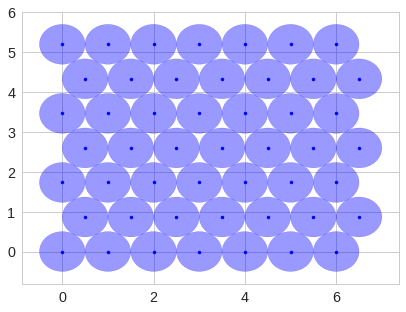

In [9]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

# Single cell dividing in tissue

## Benchmark with fixed very small time step


In [10]:
l=4
sheet = make_hexagonal_mesh(l)

Will I need to make a pre-simulation to ensure that all simulations start from an identical configuration?

## With local adaptivity

30
28
28


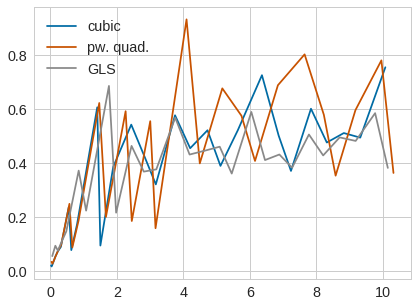

In [11]:


#force_names=['GLS']
    
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], "local_adaptivity": True, "write_to_file": True}, seed=seed)
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    
    plt.plot(ts[1:], dts, label=force, color=colors[force])
    print(len(ts))

plt.legend()

51


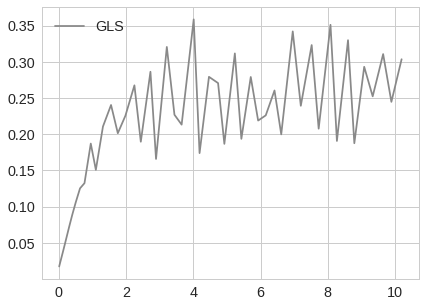

In [22]:
import jacobian as jac


g = {'cubic': ff.cubic, 'pw. quad.': ff.piecewise_polynomial, 'GLS': ff.gls }
g_prime = {'cubic': ff.cubic_prime, 'pw. quad.': ff.piecewise_polynomial_prime, 'GLS': ff.gls_prime }

#force_names = ['cubic', 'pw. quad.']
force_names = ['GLS']


for force in force_names:
    
    def A(y):
        return jac.jacobian(y, 2, g[force], g_prime[force])
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], "local_adaptivity": True, "write_to_file": True, "jacobian": A}, seed=seed)
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    
    plt.plot(ts[1:], dts, label=force, color=colors[force])
    print(len(ts))

plt.legend()

## With global adaptivity

71
62
47


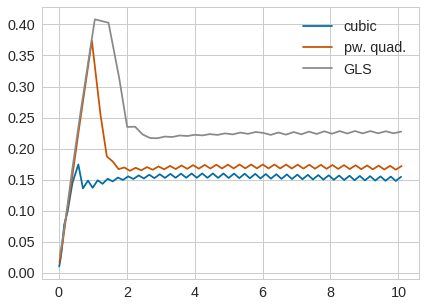

In [13]:

#force_names=['GLS']
    
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], "write_to_file": True}, seed=seed)
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    
    plt.plot(ts[1:], dts, label=force, color=colors[force])
    print(len(ts))


plt.legend()

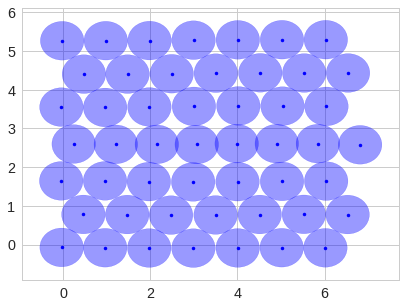

In [14]:
plot_population(history[-1])